### **Preprocessing Step**

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [4]:
# Load Excel file
df = pd.read_excel("/content/AirQualityUCI.xlsx", engine='openpyxl')

In [5]:
#Remove empty columns
df.drop(columns=['Unnamed: 15', 'Unnamed: 16'], inplace=True, errors='ignore')

In [6]:
# Create datetime column as a timestamp index
df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str),
                                 errors='coerce', dayfirst=True)
df.set_index('Datetime', inplace=True)


In [7]:
#Keep only the required inputs and outputs
df.drop(columns=['Date', 'Time'], inplace=True)


In [8]:
# Define input features and the target column
input_features = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)',
                  'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
target_column = 'C6H6(GT)'

In [9]:
# Keep only the required inputs and outputs
df = df[input_features + [target_column]].dropna()
#Normalize values between 0 and 1
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df),
                         columns=input_features + [target_column],
                         index=df.index)

In [10]:
#Print a sample of the processed data
print(df_scaled.head())

                     PT08.S1(CO)  PT08.S2(NMHC)  PT08.S3(NOx)  PT08.S4(NO2)  \
Datetime                                                                      
2004-10-03 18:00:00     0.696506       0.515949      0.435782      0.635966   
2004-10-03 19:00:00     0.666257       0.478355      0.476541      0.591176   
2004-10-03 20:00:00     0.715258       0.471935      0.464834      0.589748   
2004-10-03 21:00:00     0.703427       0.475663      0.448183      0.599580   
2004-10-03 22:00:00     0.657328       0.428956      0.487382      0.568067   

                     PT08.S5(O3)         T        RH        AH  C6H6(GT)  
Datetime                                                                  
2004-10-03 18:00:00     0.538977  0.873262  0.861979  0.992715  0.803369  
2004-10-03 19:00:00     0.430539  0.872036  0.857910  0.992555  0.793949  
2004-10-03 20:00:00     0.467909  0.866312  0.879643  0.992678  0.792434  
2004-10-03 21:00:00     0.515380  0.862633  0.900511  0.992858  0.79331

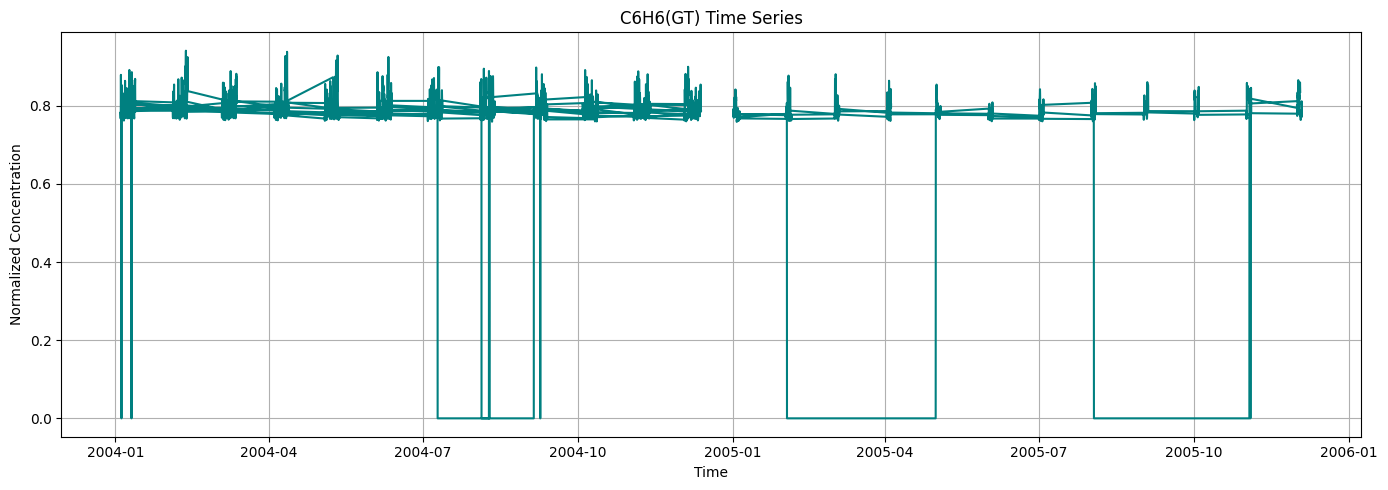

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

#1. Time series plot of C6H6 concentration (Target)
plt.figure(figsize=(14, 5))
plt.plot(df_scaled.index, df_scaled['C6H6(GT)'], color='teal')
plt.title('C6H6(GT) Time Series')
plt.xlabel('Time')
plt.ylabel('Normalized Concentration')
plt.grid(True)
plt.tight_layout()
plt.show()

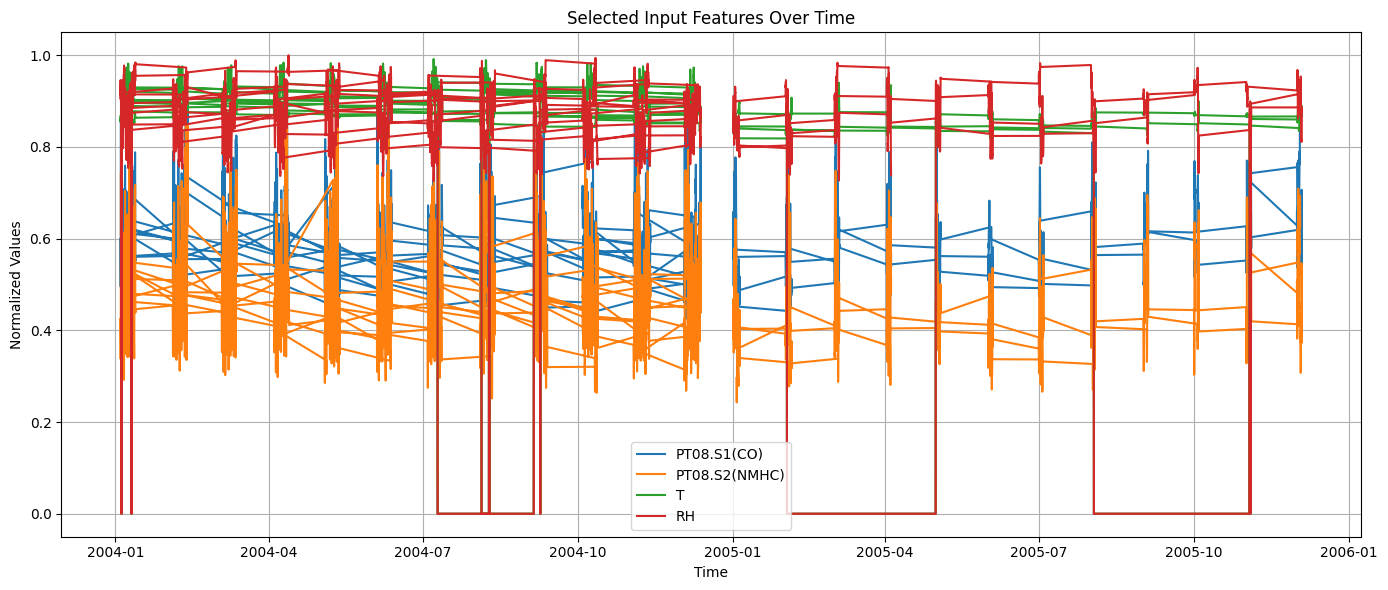

In [12]:
# 2. Time series plot of some Inputs
plt.figure(figsize=(14, 6))
for col in ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'T', 'RH']:
    plt.plot(df_scaled.index, df_scaled[col], label=col)
plt.title('Selected Input Features Over Time')
plt.xlabel('Time')
plt.ylabel('Normalized Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

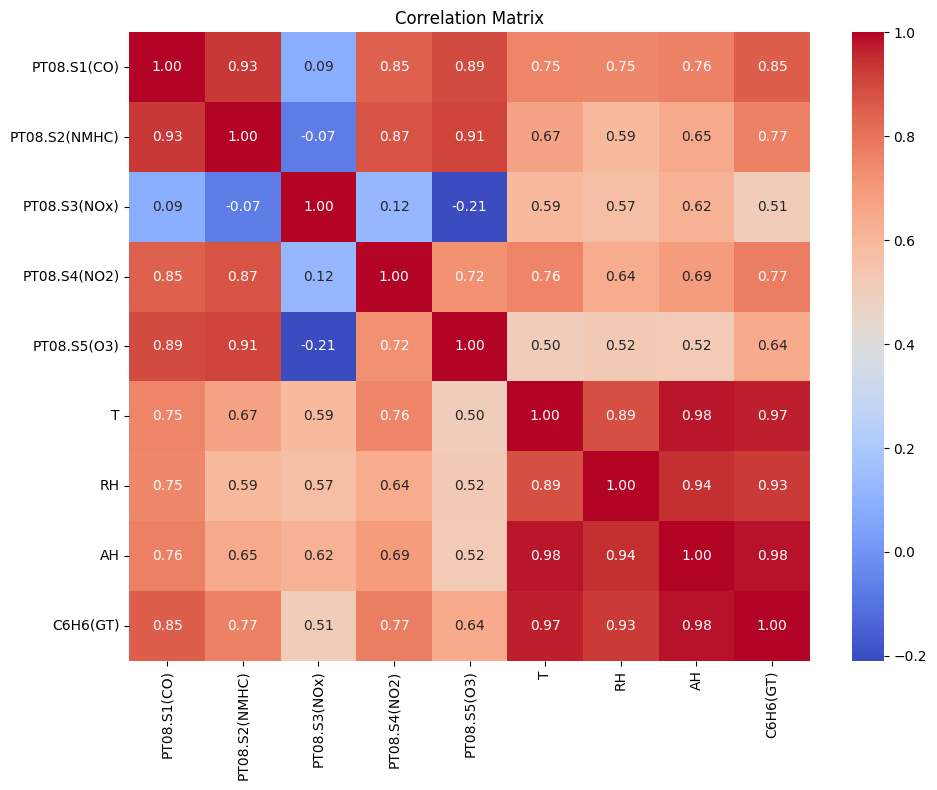

In [13]:
#===== 3. Correlation matrix (Heatmap) =====
plt.figure(figsize=(10, 8))
corr_matrix = df_scaled.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

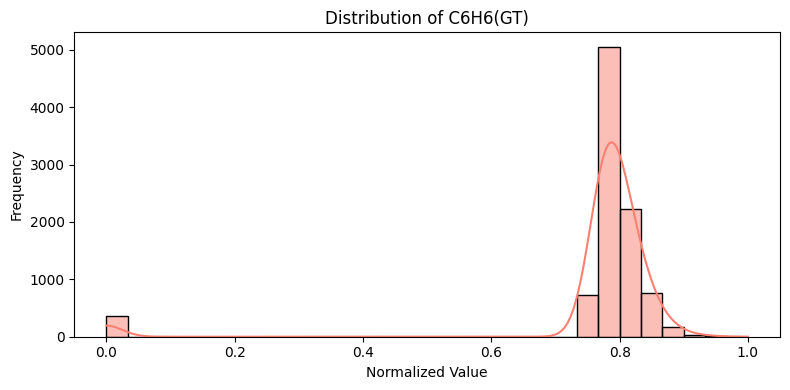

In [14]:
#4. Distribution plot for C6H6 (GT)
plt.figure(figsize=(8, 4))
sns.histplot(df_scaled['C6H6(GT)'], bins=30, kde=True, color='salmon')
plt.title('Distribution of C6H6(GT)')
plt.xlabel('Normalized Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [15]:
#Prepare the data sequence
#Number of time steps used

TIME_STEPS = 24

#Convert the data to sequences
def create_sequences(data, target_col_index, time_steps=TIME_STEPS):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps, :-1])  # جميع الأعمدة ما عدا الـ target
        y.append(data[i+time_steps, target_col_index])  # الهدف في المستقبل
    return np.array(X), np.array(y)

#Convert DataFrame to NumPy array
data_array = df_scaled.values
target_index = df_scaled.columns.get_loc("C6H6(GT)")

X, y = create_sequences(data_array, target_index, TIME_STEPS)

#Final shape of the data
print("X shape:", X.shape)  # (samples, time_steps, features)
print("y shape:", y.shape)  # (samples,)

X shape: (9333, 24, 8)
y shape: (9333,)


In [16]:
# تقسيم البيانات إلى تدريب، تحقق، واختبار بنسبة 70%، 15%، 15%
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

print("Training samples :", X_train.shape[0])
print("Validation samples:", X_val.shape[0])
print("Testing samples   :", X_test.shape[0])


Training samples : 6533
Validation samples: 1399
Testing samples   : 1401




### **ESN Model**

In [17]:
#ESN Parameters
n_reservoir = 500
spectral_radius = 0.95
input_scaling = 0.5
ridge_alpha = 1e-6
random_state = 42

np.random.seed(random_state)

In [18]:
n_input = X_train.shape[2]      # Number of features
n_output = 1                    # Predicting 1 target
time_steps = X_train.shape[1]

In [19]:
#Initialize ESN Weights
W_in = (np.random.rand(n_reservoir, n_input) - 0.5) * input_scaling
W = np.random.rand(n_reservoir, n_reservoir) - 0.5

#Scale reservoir to desired spectral radius
rho_W = max(abs(np.linalg.eigvals(W)))
W *= spectral_radius / rho_W

In [20]:
def compute_states(X):
    states = []
    for sample in X:
        x = np.zeros(n_reservoir)
        for t in range(time_steps):
            u = sample[t]
            x = np.tanh(np.dot(W_in, u) + np.dot(W, x))
        states.append(x)
    return np.array(states)

In [27]:
#Compute reservoir states
X_train_states = compute_states(X_train)
X_val_states   = compute_states(X_val)
X_test_states  = compute_states(X_test)
print("X_train_states shape:", X_train_states.shape)
print("X_val_states shape  :", X_val_states.shape)
print("X_test_states shape :", X_test_states.shape)

X_train_states shape: (6533, 500)
X_val_states shape  : (1399, 500)
X_test_states shape : (1401, 500)


In [22]:
# Train readout layer (Ridge regression)
readout = Ridge(alpha=ridge_alpha)
readout.fit(X_train_states, y_train)

Ridge(alpha=1e-06)

In [23]:
# Predict
y_val_pred = readout.predict(X_val_states)
y_test_pred = readout.predict(X_test_states)

In [24]:
def evaluate(true, pred, name):
    mse = mean_squared_error(true, pred)
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, pred)

    print(f"\n {name} Evaluation")
    print("MSE  :", mse)
    print("RMSE :", rmse)
    print("MAE  :", mae)
    print("R²   :", r2)
    print("-" * 40)

In [25]:
evaluate(y_val, y_val_pred, "Validation")
evaluate(y_test, y_test_pred, "Test")


 Validation Evaluation
MSE  : 0.008922640674743564
RMSE : 0.0944597304397147
MAE  : 0.03526003791932676
R²   : 0.8451463292809757
----------------------------------------

 Test Evaluation
MSE  : 0.0030975165869527076
RMSE : 0.05565533745250951
MAE  : 0.024943963546227264
R²   : 0.9053325098229125
----------------------------------------


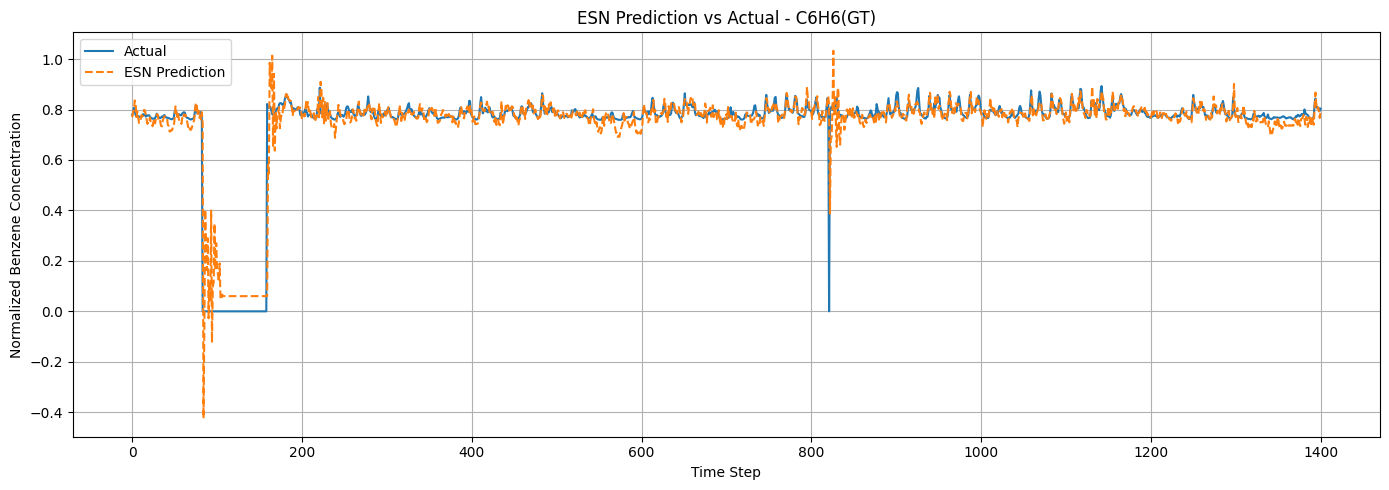

In [26]:
# Plot Test Results
plt.figure(figsize=(14, 5))
plt.plot(y_test, label="Actual")
plt.plot(y_test_pred, label="ESN Prediction", linestyle='--')
plt.title("ESN Prediction vs Actual - C6H6(GT)")
plt.xlabel("Time Step")
plt.ylabel("Normalized Benzene Concentration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()